<a href="https://colab.research.google.com/github/surajsy/ColabNotebooks/blob/master/SNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mitdeeplearning

     |████████████████████████████████| 2.1MB 3.5MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.1.2-cp36-none-any.whl size=2114586 sha256=a1f40bf9f70b337981c373974a381f9013d5e84f84ba8ae1733198e212bc6f07
  Stored in directory: /root/.cache/pip/wheels/27/e1/73/5f01c787621d8a3c857f59876c79e304b9b64db9ff5bd61b74
Successfully built mitdeeplearning


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

import mitdeeplearning as mdl

assert len(tf.config.list_physical_devices('GPU')) > 0

Using TensorFlow backend.


In [ ]:
# Saved in the d2l package for later use
def read_snli():
  snli_data = tfds.load('snli',download=True)
  snli_train = snli_data['train']
  snli_test = snli_data['test']
  snli_validation = snli_data['validation']
  return snli_train, snli_validation, snli_test

def preprocess_snli(dataset, tokenizer=None):
  dataset = list(dataset.as_numpy_iterator())
  premise = [d['premise'].decode('utf-8') for d in dataset if d['label']>=0]
  hypothesis = [d['hypothesis'].decode('utf-8') for d in dataset if d['label']>=0]
  label = np.array([d['label'] for d in dataset if d['label']>=0])

  if(tokenizer == None):
    tokenizer = Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(premise + hypothesis)
    print('success')
  
  premise_seq = pad_sequences(tokenizer.texts_to_sequences(premise),maxlen=50)
  hypothesis_seq = pad_sequences(tokenizer.texts_to_sequences(hypothesis),maxlen=50)
  if(tokenizer != None):
    return premise_seq, hypothesis_seq, label, tokenizer
  else:
    return premise_seq, hypothesis_seq, label

In [ ]:
train, val, test = read_snli()

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/snli/plain_text/1.0.0.incompleteXV1KRL/snli-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/snli/plain_text/1.0.0.incompleteXV1KRL/snli-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/snli/plain_text/1.0.0.incompleteXV1KRL/snli-train.tfrecord


Dataset snli downloaded and prepared to /root/tensorflow_datasets/snli/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
premise, hypothesis, label, tokenizer = preprocess_snli(train)

success


In [ ]:
np.min(label)

0

In [ ]:
def get_batch(premise,hypothesis,label,batch_size):
  idx = np.random.choice(len(premise),batch_size)
  premise_batch = premise[idx]
  hypothesis_batch = hypothesis[idx]
  label_batch = np.array(label)[idx]
  return premise_batch, hypothesis_batch, label_batch

p, h, l = get_batch(premise,hypothesis,label,128)

In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_normal',
    recurrent_activation='sigmoid',
    stateful=False
  )

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, seq_length, batch_size):
  lstm1 = tf.keras.layers.Bidirectional(LSTM(rnn_units))
  lstm2 = tf.keras.layers.Bidirectional(LSTM(rnn_units))
  lstm3 = tf.keras.layers.Bidirectional(LSTM(rnn_units))
  embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
  dense300 = tf.keras.layers.Dense(300,activation='tanh')
  dense1 = tf.keras.layers.Dense(1024,activation='relu')
  dense2 = tf.keras.layers.Dense(1024,activation='relu')
  dense3 = tf.keras.layers.Dense(1024,activation='relu')

  dropout1 = tf.keras.layers.Dropout(0.2)
  dropout2 = tf.keras.layers.Dropout(0.2)
  dropout3 = tf.keras.layers.Dropout(0.2)

  premise = tf.keras.layers.Input(shape=(seq_length,),batch_size=batch_size,name='premise')
  emb_prem = embed(premise)
  proj_prem = dense300(emb_prem)
  lstm_prem = lstm1(proj_prem)
  lstm_prem = lstm2(lstm_prem)
  lstm_prem = lstm3(lstm_prem)

  hypothesis = tf.keras.layers.Input(shape=(seq_length,),batch_size=batch_size,name='hypothesis')
  emb_hypo = embed(hypothesis)
  proj_hypo = dense300(emb_hypo)
  lstm_hypo = lstm1(proj_hypo)
  lstm_hypo = lstm2(lstm_hypo)
  lstm_hypo = lstm3(lstm_hypo)

  lstm_prem = tf.math.reduce_sum(lstm_prem,axis=1)
  lstm_hypo = tf.math.reduce_sum(lstm_hypo,axis=1)

  out = tf.keras.layers.concatenate([lstm_prem,lstm_hypo],axis=1)
  out = dropout1(dense1(out))
  out = dropout2(dense2(out))
  out = dropout3(dense3(out))
  out = tf.keras.layers.Dense(3)(out)

  model = tf.keras.Model(inputs=[premise,hypothesis],outputs=[out])
  return model

In [ ]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

In [ ]:
num_training_iterations = 5000
batch_size = 256
seq_length = None
learning_rate = 1e-4

In [ ]:
vocab_size = 20000
embedding_dim = 512
rnn_units = 512

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, seq_length, batch_size)
# model = build_model2(vocab_size, embedding_dim, seq_length, batch_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
premise (InputLayer)            [(256, None)]        0                                            
__________________________________________________________________________________________________
hypothesis (InputLayer)         [(256, None)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (256, None, 512)     10240000    premise[0][0]                    
                                                                 hypothesis[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (256, None, 300)     153900      embedding[0][0]              

In [ ]:
# model = build_model2(vocab_size, embedding_dim, seq_length, batch_size)
model = build_model(vocab_size, embedding_dim, rnn_units, seq_length, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(p, h, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model([p,h])
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

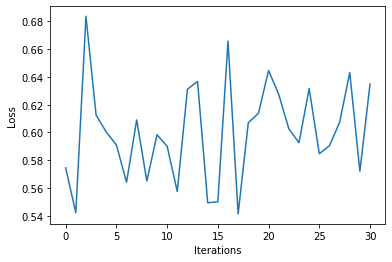

 33%|███▎      | 1633/5000 [15:22<31:45,  1.77it/s]

KeyboardInterrupt: ignored

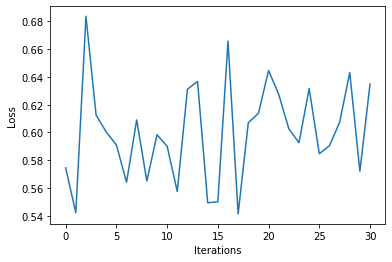

In [ ]:
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  p, h, l = get_batch(premise,hypothesis,label,batch_size)
  loss = train_step(p, h, l)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    history.clear()
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
!zip -r training_checkpoint.zip training_checkpoints/
from google.colab import drive
drive.mount('/content/gdrive')
!cp training_checkpoint.zip /content/gdrive/My\ Drive

updating: training_checkpoints/ (stored 0%)
updating: training_checkpoints/my_ckpt.data-00001-of-00002 (deflated 7%)
updating: training_checkpoints/my_ckpt.index (deflated 70%)
updating: training_checkpoints/checkpoint (deflated 38%)
updating: training_checkpoints/my_ckpt.data-00000-of-00002 (deflated 7%)
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
